In [33]:
## Import packages

import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split, LeaveOneOut, ShuffleSplit, RepeatedKFold, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# Importing the Packages:
#import optuna  # import by `$ pip install optuna`
#import pandas as pd
#from sklearn import linear_model
#from sklearn import ensemble
#from sklearn import datasets
#from sklearn import model_selection

In [3]:
# Load data
dataPath = './peru_for_ml_course.csv'
peru = pd.read_csv(dataPath, sep =",")
peru.head()

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,...,d_lux_4,d_lux_5,training,percapitaconsumption,poor,h_hhsize,id_for_matlab,hhid,lncaphat_OLS,percapitahat_OLS
0,NaN,0,1,0,0,0,0,0,0,1,...,0,0,0,NaN,0,1,1,233710511,5.246471,284.4243
1,NaN,0,0,0,0,1,0,0,0,0,...,0,0,0,NaN,0,3,2,295508011,6.129468,522.8840
2,NaN,0,0,0,0,1,0,0,0,0,...,0,0,0,NaN,0,4,3,257600211,6.665577,878.4961
3,NaN,0,0,0,0,1,0,0,0,0,...,0,0,0,NaN,1,9,4,198104311,6.088295,567.4705
4,NaN,0,1,0,0,0,0,0,0,1,...,0,0,0,NaN,1,8,5,24805311,5.008170,115.4929


In [4]:
## Prepare training data
peruTraining = peru.copy(deep=True)
peruTraining.dropna(axis='index', inplace=True)
peruTraining.drop(['id_for_matlab', 'poor', 'hhid', 'training', 'percapitaconsumption', 'lncaphat_OLS', 'percapitahat_OLS'], axis='columns', inplace=True)
peruTraining.head()

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,...,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_0,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5,h_hhsize
23152,5.304770,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,2
23153,7.179197,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,1,0,3
23154,5.546008,0,1,0,0,0,0,0,0,0,...,1.0,0.0,0.0,1,0,0,0,0,0,2
23155,5.321395,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1,0,0,0,0,0,7
23156,5.347988,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1,0,0,0,0,0,4


# Winsorizing

(array([5.775e+03, 8.483e+03, 5.850e+03, 1.259e+03, 9.870e+02, 2.460e+02,
        3.100e+01, 3.300e+01, 9.000e+00, 1.000e+00]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <BarContainer object of 10 artists>)

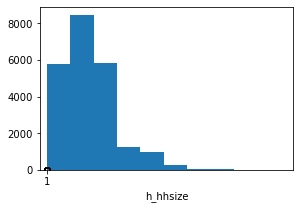

In [5]:
# h_hhid is the only non-dummy variable which coudl be winsorized
peruTraining['h_hhsize'].value_counts(dropna=False).sort_index(ascending = True)
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1,2,1)
ax1.boxplot(peruTraining['h_hhsize'])
ax1.set_xlabel('h_hhsize')
plt.hist(peruTraining['h_hhsize'])

In [6]:
from scipy.stats.mstats import winsorize

(array([2552., 3223., 3840.,    0., 4643., 3583.,    0., 2267., 1259.,
        1307.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

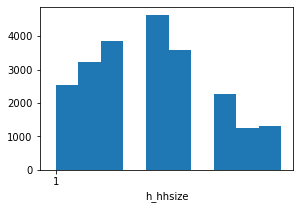

In [7]:
#winsorization only on the higher end since lower end wouldn't make sense (min. 1 person per houshold)
winsorize(a=peruTraining['h_hhsize'], limits=[0., 0.05], inplace=True)
peruTraining['h_hhsize'].value_counts(dropna=False).sort_index(ascending = True)
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1,2,1)
ax1.boxplot(peruTraining['h_hhsize'])
ax1.set_xlabel('h_hhsize')
plt.hist(peruTraining['h_hhsize'])

# Prepare training data and Helper function

In [8]:
X = peruTraining.drop('lnpercapitaconsumption', axis='columns')
y = peruTraining['lnpercapitaconsumption']
X.describe()
print(len(y))

22674


In [9]:
scorers = ['neg_mean_squared_error', 'r2', 'max_error']

def print_best_scores(name, model):
  print("{name}: parameters:", model.best_params_)
  print("{name}: best score:", model.best_score_)

def print_all_metrics(name, y, predictions):
  print(f"{name} r2:", metrics.r2_score(y, predictions))
  print(f"{name} explained_variance_score:", metrics.explained_variance_score(y, predictions))
  print(f"{name} max_error:", metrics.max_error(y, predictions))
  print(f"{name} mean absolute error:", metrics.mean_absolute_error(y, predictions))
  print(f"{name} mean squared error:", metrics.mean_squared_error(y, predictions))

def print_model_metrics(name, model):
  predictions = model.predict(X)
  print_all_metrics(name, y, predictions)

def getRegressor(model):
  return model.named_steps['regressor']

def plotCoefs(title, pipe):
  coefs = pd.DataFrame(getRegressor(pipe).coef_, columns=['Coefficients'], index=X.columns)
  coefs.plot(kind='barh')
  plt.title(title)
  plt.axvline(x=0, color='.5')
  # plt.subplots_adjust(left=.3)

## Regression OLS

OLS r2: 0.6870197069844055
OLS explained_variance_score: 0.687019729420299
OLS max_error: 3.0693524296875
OLS mean absolute error: 0.32346850535304755
OLS mean squared error: 0.17411577628728306


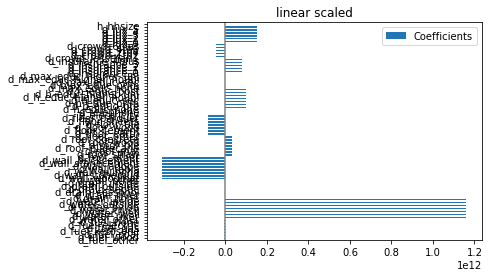

In [10]:
linear = LinearRegression()
linear = Pipeline([('scaler', MinMaxScaler()), ('regressor', linear)])
linear.fit(X, y)
print_model_metrics("OLS", linear)
plotCoefs('linear scaled', linear)

In [11]:
#Call the coefficient
coefs = pd.DataFrame(getRegressor(linear).coef_, columns=['Coefficients'], index=X.columns)
print(coefs)

                 Coefficients
d_fuel_other    -4.372460e+09
d_fuel_wood     -4.372460e+09
d_fuel_coal     -4.372460e+09
d_fuel_kerosene -4.372460e+09
d_fuel_gas      -4.372460e+09
...                       ...
d_lux_2          1.542580e+11
d_lux_3          1.542580e+11
d_lux_4          1.542580e+11
d_lux_5          1.542580e+11
h_hhsize        -7.674561e-01

[73 rows x 1 columns]


## Ridge Regression

In [12]:
def ridgeInvestigate(alphas):

# Find what sort of magnitude we should be using
  ridge = RidgeCV(alphas=alphas, cv=None, store_cv_values=True)
  ridgepipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', ridge)])

  ridgepipe.fit(X, y)

# plot alphas
  fig = plt.figure()
  f1 = fig.add_subplot(1,2,1)
  f1.plot(ridge.alphas, ridge.cv_values_.mean(0))

  f1.set_xlabel("alpha")
  f1.set_xscale("log")
  f1.set_ylabel("mean squared error")
  f1.set_title("RidgeCV Alpha Error")

  f2 = fig.add_subplot(1,2,2)
  f2.plot(ridge.alphas, np.abs(ridge.cv_values_).max(0))
  f2.set_xlabel("alpha")
  f2.set_xscale("log")
  f2.set_ylabel("worstcase mean squared error")
  f2.set_title("RidgeCV Alpha Error")
  print();
  print("ridge alpha", ridge.alpha_)
  print("ridge best_score:", ridge.best_score_)
  print("ridge:", ridge)
  print()
  print_model_metrics("ridge", ridgepipe)
  plotCoefs('ridge scaled', ridgepipe)
  return ridgepipe


ridge alpha 3.5481338923357533
ridge best_score: -0.17514332146312533
ridge: RidgeCV(alphas=array([ 0.01      ,  0.01412538,  0.01995262,  0.02818383,  0.03981072,
        0.05623413,  0.07943282,  0.11220185,  0.15848932,  0.22387211,
        0.31622777,  0.44668359,  0.63095734,  0.89125094,  1.25892541,
        1.77827941,  2.51188643,  3.54813389,  5.01187234,  7.07945784,
       10.        ]),
        store_cv_values=True)

ridge r2: 0.6870338274145269
ridge explained_variance_score: 0.6870338274145269
ridge max_error: 3.075018939465144
ridge mean absolute error: 0.3234891235554816
ridge mean squared error: 0.17410792087367727


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 RidgeCV(alphas=array([ 0.01      ,  0.01412538,  0.01995262,  0.02818383,  0.03981072,
        0.05623413,  0.07943282,  0.11220185,  0.15848932,  0.22387211,
        0.31622777,  0.44668359,  0.63095734,  0.89125094,  1.25892541,
        1.77827941,  2.51188643,  3.54813389,  5.01187234,  7.07945784,
       10.        ]),
                         store_cv_values=True))])

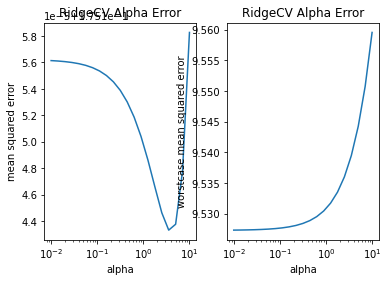

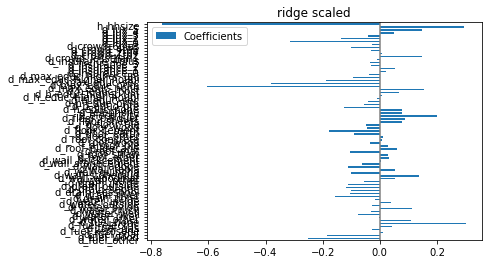

In [13]:
ridgeInvestigate(np.logspace(-2, 1, 21))


ridge alpha 3.9625960107014238
ridge best_score: -0.17514320172342934
ridge: RidgeCV(alphas=array([1.        , 1.01878093, 1.03791459, 1.05740759, 1.07726669,
       1.09749877, 1.11811082, 1.13910998, 1.16050353, 1.18229887,
       1.20450354, 1.22712524, 1.2501718 , 1.27365119, 1.29757154,
       1.32194115, 1.34676844, 1.372062  , 1.39783061, 1.42408317,
       1.45082878, 1.4780767 , 1.50583635, 1.53411737, 1.56292952,
       1.59228279, 1.62218735, 1.65265354, 1.68369191, 1.71531322,
       1.7475284 ,...
       3.67837977, 3.74746317, 3.81784403, 3.8895467 , 3.96259601,
       4.03701726, 4.11283621, 4.19007911, 4.2687727 , 4.34894423,
       4.43062146, 4.51383266, 4.59860665, 4.68497277, 4.77296092,
       4.86260158, 4.95392577, 5.04696512, 5.14175183, 5.23831872,
       5.33669923, 5.43692742, 5.53903799, 5.64306628, 5.74904833,
       5.85702082, 5.96702113, 6.07908735, 6.19325828, 6.30957344]),
        store_cv_values=True)

ridge r2: 0.6870308645282799
ridge explained_var

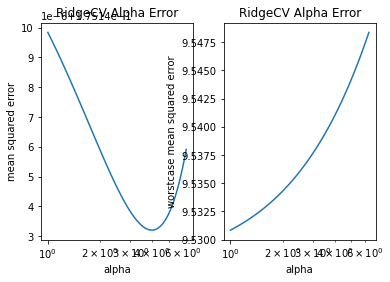

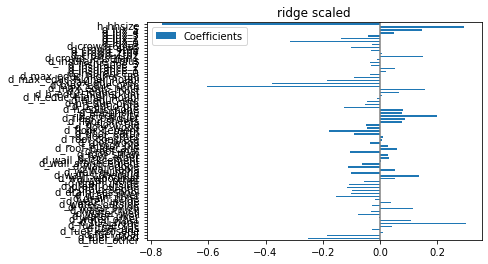

In [14]:
#Optimized & selected best predictor
ridgepipe = ridgeInvestigate(10**np.linspace(0,0.8, 100))

## Lasso Regression

In [15]:
def lassoInvestigate(alphas, cv=20):

  # Find what sort of magnitude we should be using
  lasso = LassoCV(alphas=alphas, cv=cv, max_iter=100000)
  lassopipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', lasso)])

  lassopipe.fit(X, y)

  # plot alphas
  fig = plt.figure()
  f1 = fig.add_subplot(1,2,1)
  f1.plot(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))
  f1.set_xlabel("alpha")
  f1.set_xscale("log")
  f1.set_ylabel("mean squared error")
  f1.set_title("LassoCV Alpha Error")

  f2 = fig.add_subplot(1,2,2)
  f2.plot(lasso.alphas_, np.abs(lasso.mse_path_).max(axis=1))
  f2.set_xlabel("alpha")
  f2.set_xscale("log")
  f2.set_ylabel("worstcase mean squared error")
  f2.set_title("LassoCV Alpha Error")
  print();
  print("lasso alpha", lasso.alpha_)
  print("lasso best_score:", lasso.score(X,y))
  print("lasso:", lasso)
  print()
  print_model_metrics("lasso", lassopipe)
  plotCoefs('lasso scaled', lassopipe)
  return lassopipe


lasso alpha 0.0001
lasso best_score: -15.397113640147971
lasso: LassoCV(alphas=array([1.00000000e-04, 1.58489319e-04, 2.51188643e-04, 3.98107171e-04,
       6.30957344e-04, 1.00000000e-03, 1.58489319e-03, 2.51188643e-03,
       3.98107171e-03, 6.30957344e-03, 1.00000000e-02, 1.58489319e-02,
       2.51188643e-02, 3.98107171e-02, 6.30957344e-02, 1.00000000e-01,
       1.58489319e-01, 2.51188643e-01, 3.98107171e-01, 6.30957344e-01,
       1.00000000e+00]),
        cv=20, max_iter=100000)

lasso r2: 0.6869221017255459
lasso explained_variance_score: 0.686922101725546
lasso max_error: 3.073332726821687
lasso mean absolute error: 0.32357950622606707
lasso mean squared error: 0.17417007560195336


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 LassoCV(alphas=array([1.00000000e-04, 1.58489319e-04, 2.51188643e-04, 3.98107171e-04,
       6.30957344e-04, 1.00000000e-03, 1.58489319e-03, 2.51188643e-03,
       3.98107171e-03, 6.30957344e-03, 1.00000000e-02, 1.58489319e-02,
       2.51188643e-02, 3.98107171e-02, 6.30957344e-02, 1.00000000e-01,
       1.58489319e-01, 2.51188643e-01, 3.98107171e-01, 6.30957344e-01,
       1.00000000e+00]),
                         cv=20, max_iter=100000))])

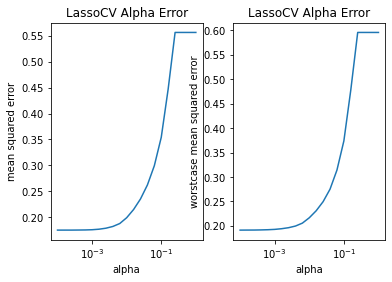

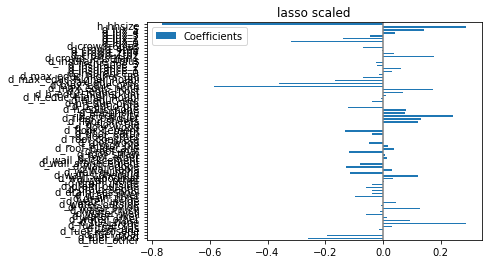

In [16]:
lassoInvestigate(np.logspace(-4, 0, 21))


lasso alpha 0.001
lasso best_score: -14.822186653081824
lasso: LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=20, max_iter=100000)


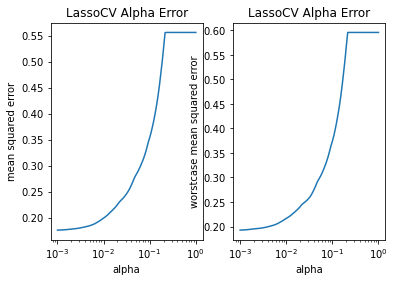

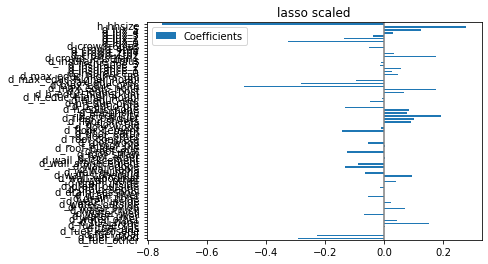

In [17]:
#Lasso is just bad
lassopipe = lassoInvestigate(10**np.linspace(-3,0, 100))

## Averaging Lasso and Ridge 

In [18]:
avg_predictions = (lassopipe.predict(X) + ridgepipe.predict(X)) / 2.0
print_all_metrics('averaged', y, avg_predictions)

averaged r2: 0.6865410615471932
averaged explained_variance_score: 0.6865410615471932
averaged max_error: 3.081548552625037
averaged mean absolute error: 0.323746910363075
averaged mean squared error: 0.17438205414479163


# ElasticNet

In [19]:
def elasticInvestigate(l1_ratios, cv=20):
  cv=20
# Find what sort of magnitude we should be using
  elastic = ElasticNetCV(l1_ratio=l1_ratios, cv=cv, eps=1e-8, max_iter=100000, n_jobs=-1)
  elasticpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', elastic)])
  elasticpipe.fit(X, y)

# plot alphas
  fig = plt.figure()
  f1 = fig.add_subplot(1,2,1)
  for (a,m) in zip(elastic.alphas_, np.mean(elastic.mse_path_, axis=2)):   
     f1.scatter(a, m)
  f1.set_xlabel("alpha")
  f1.set_xscale("log")
  f1.set_title("ElasticCV MSE")
  print();
  print("elastic alpha", elastic.alpha_)
  print("elastic best_score:", elastic.score(X,y))
  print("elastic:", elastic)
  print()
  print_model_metrics("elastic", elasticpipe)
  plotCoefs('elastic scaled', elasticpipe)
  return elasticpipe


elastic alpha 0.00014770003529067407
elastic best_score: -15.291598269632175
elastic: ElasticNetCV(cv=20, eps=1e-08,
             l1_ratio=array([1.00000000e-04, 1.58489319e-04, 2.51188643e-04, 3.98107171e-04,
       6.30957344e-04, 1.00000000e-03, 1.58489319e-03, 2.51188643e-03,
       3.98107171e-03, 6.30957344e-03, 1.00000000e-02, 1.58489319e-02,
       2.51188643e-02, 3.98107171e-02, 6.30957344e-02, 1.00000000e-01,
       1.58489319e-01, 2.51188643e-01, 3.98107171e-01, 6.30957344e-01,
       1.00000000e+00]),
             max_iter=100000, n_jobs=-1)

elastic r2: 0.6870283747797244
elastic explained_variance_score: 0.6870283747797244
elastic max_error: 3.0748235493463483
elastic mean absolute error: 0.3234949815150262
elastic mean squared error: 0.1741109542587262


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 ElasticNetCV(cv=20, eps=1e-08,
                              l1_ratio=array([1.00000000e-04, 1.58489319e-04, 2.51188643e-04, 3.98107171e-04,
       6.30957344e-04, 1.00000000e-03, 1.58489319e-03, 2.51188643e-03,
       3.98107171e-03, 6.30957344e-03, 1.00000000e-02, 1.58489319e-02,
       2.51188643e-02, 3.98107171e-02, 6.30957344e-02, 1.00000000e-01,
       1.58489319e-01, 2.51188643e-01, 3.98107171e-01, 6.30957344e-01,
       1.00000000e+00]),
                              max_iter=100000, n_jobs=-1))])

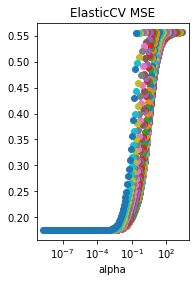

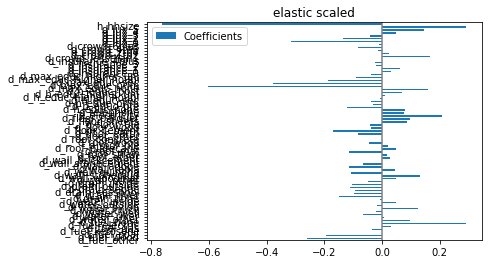

In [20]:
elasticInvestigate(np.logspace(-4, 0, 21))


elastic alpha 0.0001872452899650686
elastic best_score: -15.230949744695316
elastic: ElasticNetCV(cv=20, eps=1e-08,
             l1_ratio=array([1.00000000e-05, 1.29154967e-05, 1.66810054e-05, 2.15443469e-05,
       2.78255940e-05, 3.59381366e-05, 4.64158883e-05, 5.99484250e-05,
       7.74263683e-05, 1.00000000e-04]),
             max_iter=100000, n_jobs=-1)

elastic r2: 0.6870287130902766
elastic explained_variance_score: 0.6870287130902766
elastic max_error: 3.0753979855725646
elastic mean absolute error: 0.32349421053623895
elastic mean squared error: 0.1741107660513351


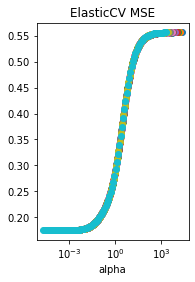

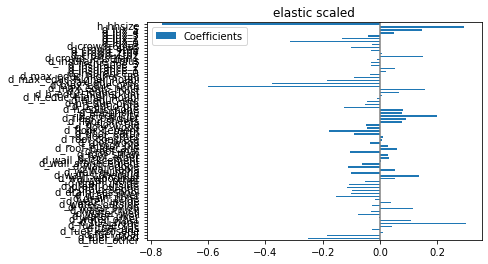

In [21]:
#Optimized & safe best predictor
elasticpipe = elasticInvestigate(10**np.linspace(-5,-4, 10))

## KNN-Regressor

### Without Winsorizing

In [22]:
## Get non-winsorized data Prepare training data
peruTraining = peru.copy(deep=True)
peruTraining.dropna(axis='index', inplace=True)
peruTraining.drop(['id_for_matlab', 'poor', 'hhid', 'training', 'percapitaconsumption', 'lncaphat_OLS', 'percapitahat_OLS'], axis='columns', inplace=True)
peruTraining.head()
y = peruTraining['lnpercapitaconsumption']
X = peruTraining.drop('lnpercapitaconsumption', axis='columns')


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [23]:
# Compare winsorizing vs not
from sklearn.neighbors import KNeighborsRegressor
def knnrInvestigate(nn):
  # Find what sort of magnitude we should be using
  knnr = KNeighborsRegressor(n_neighbors=nn, n_jobs=-1)
  knnrpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', knnr)])

  results = cross_validate(knnrpipe, X, y, cv=20, n_jobs=None, verbose=True, scoring=scorers)
  print(results)
  return results, knnrpipe

knnrs = []
results = []
for i in range(2, 5):
    print(i)
    result, knnr = knnrInvestigate(i)
    results.append(result)
    knnrs.append(knnr)
print( [np.mean(knn['test_r2']) for knn in results]) # (last output line) we see higher k is better for r2 score

2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   42.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.82600093, 0.83976889, 0.78055811, 0.76542902, 0.75778508,
       0.76381803, 0.7811501 , 0.76385379, 0.90208173, 0.75675797,
       0.76258206, 0.77252316, 0.76752901, 0.77259612, 0.79706407,
       0.76308203, 0.93613195, 0.79792595, 0.7798059 , 0.78110313]), 'score_time': array([2.99267817, 1.22731304, 1.22514892, 1.2597959 , 1.26081681,
       1.21096206, 1.27885795, 1.281739  , 1.21171308, 1.22656322,
       1.23737764, 1.20121098, 1.24472284, 1.25429702, 1.25434923,
       1.26156425, 1.26374626, 1.2238059 , 1.24479103, 1.24063897]), 'test_neg_mean_squared_error': array([-0.25874016, -0.26212617, -0.27759858, -0.2558931 , -0.27849165,
       -0.27506646, -0.26274456, -0.28238455, -0.25900994, -0.26498706,
       -0.25357243, -0.27023102, -0.25175364, -0.28266233, -0.25046551,
       -0.24916318, -0.25807861, -0.26579792, -0.26706481, -0.26239711]), 'test_r2': array([0.53160065, 0.54553381, 0.47665976, 0.53197299, 0.50055068,
       0.50185651, 0.51542248, 0.4

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   41.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.78328824, 0.84492207, 0.78273606, 0.8324759 , 0.76578879,
       0.75824809, 0.76200795, 0.77947593, 0.76065421, 0.76427102,
       0.7576232 , 0.75934005, 0.79275107, 0.75288725, 0.76716805,
       0.76118088, 0.75303411, 0.77360106, 0.75915694, 0.76165819]), 'score_time': array([1.31603694, 1.24485803, 1.25853086, 1.27804399, 1.36009908,
       1.34678674, 1.25012732, 1.2749629 , 1.31441593, 1.24155903,
       1.37333393, 1.2922771 , 1.30209422, 1.27000785, 1.31920385,
       1.35723019, 1.30041003, 1.29669905, 1.26201606, 1.30622888]), 'test_neg_mean_squared_error': array([-0.22610432, -0.23201229, -0.24289624, -0.22994799, -0.24229761,
       -0.24185747, -0.22233266, -0.25639247, -0.23539522, -0.24416067,
       -0.23495372, -0.23730825, -0.22794506, -0.25635428, -0.21583149,
       -0.22281627, -0.23557101, -0.22618743, -0.2346861 , -0.22962251]), 'test_r2': array([0.59068157, 0.59774433, 0.54208204, 0.57942645, 0.56546138,
       0.56199777, 0.5899538 , 0.5

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   42.7s finished


### With winsorizing

In [42]:
#With winsorizing
peruTraining['h_hhsize'].value_counts(dropna=False).sort_index(ascending = True)
from scipy.stats.mstats import winsorize
winsorize(a=peruTraining['h_hhsize'], limits=[0., 0.05], inplace=True)
peruTraining['h_hhsize'].value_counts(dropna=False).sort_index(ascending = True)
y = peruTraining['lnpercapitaconsumption']
X = peruTraining.drop('lnpercapitaconsumption', axis='columns')

In [45]:
#With winsorized + higher cross validation - the more you add the "better" MSE
from sklearn.neighbors import KNeighborsRegressor
def knnrInvestigate(nn):
  # Find what sort of magnitude we should be using
  knnr = KNeighborsRegressor(n_neighbors=nn, n_jobs=-1)
  knnrpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', knnr)])

  results = cross_validate(knnrpipe, X, y, cv=20, n_jobs=None, verbose=True, scoring=scorers)
  print(results)
  return results, knnrpipe

knnrs = []
results = []
for i in range(2, 5):
    print(i)
    result, knnr = knnrInvestigate(i)
    results.append(result)
    knnrs.append(knnr)
    

# Here we see winzorized data is worse for knns.
    
# Again we see higher k is better for r2 score
print( [np.mean(knn['test_r2']) for knn in results])





2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   43.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.96839094, 0.80002999, 0.77983713, 0.78157401, 0.77470899,
       0.75852227, 0.77126598, 0.75583267, 0.79770708, 0.77315664,
       0.75847912, 0.7704618 , 0.76944399, 0.76708007, 0.77158999,
       0.76332307, 0.79853511, 0.76357198, 0.7930541 , 0.76878309]), 'score_time': array([2.9553709 , 1.22536302, 1.25046492, 1.36515093, 1.22141218,
       1.23004889, 1.3404429 , 1.3953042 , 1.29633904, 1.24214029,
       1.28203177, 1.36843085, 1.2716701 , 1.22860003, 1.26074409,
       1.3056829 , 1.32505989, 1.25421309, 1.22040582, 1.32118988]), 'test_neg_mean_squared_error': array([-0.25836057, -0.26105348, -0.27605959, -0.2574454 , -0.27706081,
       -0.27709551, -0.2633594 , -0.28251869, -0.25932988, -0.26579078,
       -0.25590636, -0.27140244, -0.25065736, -0.28283345, -0.25090822,
       -0.24762893, -0.25997702, -0.26847406, -0.26947026, -0.26348419]), 'test_r2': array([0.53228782, 0.54739361, 0.47956114, 0.52913385, 0.50311676,
       0.4981819 , 0.51428854, 0.4

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   42.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.76603699, 0.80639482, 0.76105809, 0.79899406, 0.76696396,
       0.77242184, 0.78117895, 0.7599411 , 0.77508116, 0.76851201,
       0.75016904, 0.77175117, 0.77011108, 0.80048704, 0.7591908 ,
       0.768296  , 0.75228906, 0.76923776, 0.75180268, 0.76740193]), 'score_time': array([1.28910804, 1.25840211, 1.36045003, 1.32870078, 1.26429796,
       1.35347104, 1.31195807, 1.28443098, 1.2740531 , 1.31139922,
       1.32671905, 1.29320812, 1.41866899, 1.36231184, 1.29028606,
       1.38853407, 1.36556506, 1.35762501, 1.29315209, 1.29143095]), 'test_neg_mean_squared_error': array([-0.2265849 , -0.23174923, -0.24308831, -0.23039483, -0.24243789,
       -0.2427781 , -0.22221679, -0.25538043, -0.23565126, -0.24452903,
       -0.23421142, -0.23642517, -0.22567627, -0.25558134, -0.21587017,
       -0.22275411, -0.23598566, -0.22698975, -0.23556671, -0.23064076]), 'test_r2': array([0.58981156, 0.59820042, 0.54171994, 0.57860918, 0.5652098 ,
       0.56033051, 0.59016749, 0.5

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   43.1s finished


In [47]:
# Higher k for lower variance, higher bias
#Give us the r^2 for each k
for i in range(5, 15):
    print(i)
    result, knnr = knnrInvestigate(i)
    results.append(result)
    knnrs.append(knnr)
print( [np.mean(knn['test_r2']) for knn in results])



5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   55.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.89349675, 0.89021802, 0.76324797, 0.75925899, 1.52995396,
       1.67406511, 2.51495719, 1.92735696, 1.03096318, 1.14858484,
       1.24510479, 0.81738687, 0.78009224, 0.78775001, 0.80038786,
       0.81385207, 0.82251072, 0.80438781, 0.80970192, 0.77574015]), 'score_time': array([1.34225726, 2.22530508, 1.38267899, 2.01034808, 1.76407313,
       1.97500205, 1.86696601, 1.81130385, 2.0317719 , 2.71115398,
       2.04554224, 1.57033992, 1.40651011, 1.39162898, 1.41167617,
       1.40577388, 1.38264418, 1.41286302, 1.38812995, 1.41367292]), 'test_neg_mean_squared_error': array([-0.20204446, -0.21018495, -0.22438131, -0.20082046, -0.22263404,
       -0.21463156, -0.20312284, -0.2310519 , -0.21008161, -0.21615821,
       -0.20168226, -0.20927388, -0.20202522, -0.23259469, -0.19720867,
       -0.20474996, -0.21841873, -0.20860752, -0.21727424, -0.2084973 ]), 'test_r2': array([0.63423733, 0.63558788, 0.57698714, 0.63270053, 0.60072621,
       0.6113037 , 0.6253823 , 0.5

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   46.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.79260397, 0.80327821, 0.78591895, 0.79972887, 0.79384089,
       0.80202794, 0.794559  , 0.80119014, 0.77877712, 0.80880523,
       0.7824471 , 0.78913808, 0.81937814, 0.79236197, 0.80481887,
       1.67535377, 0.79470706, 0.80015206, 0.79105997, 1.04788995]), 'score_time': array([1.46461987, 1.37090278, 1.37533903, 1.41426682, 1.41745806,
       1.419379  , 1.37344384, 1.38523412, 1.39064407, 1.37783384,
       1.41566992, 1.44005609, 1.36955881, 1.37914276, 1.66570926,
       1.82307005, 1.460742  , 1.47279787, 1.62100673, 1.53263497]), 'test_neg_mean_squared_error': array([-0.19568892, -0.20378359, -0.22317847, -0.19586154, -0.21552664,
       -0.21062238, -0.19481724, -0.22447781, -0.20734767, -0.21358385,
       -0.19448019, -0.20523201, -0.19397133, -0.22792632, -0.19197606,
       -0.20095085, -0.21462513, -0.20291219, -0.20674359, -0.20471162]), 'test_r2': array([0.64574281, 0.64668636, 0.5792548 , 0.64177036, 0.61347267,
       0.6185643 , 0.64070025, 0.5

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.90194702, 0.84040022, 0.85499811, 0.76835012, 0.78128886,
       0.80209208, 0.81899691, 0.79689908, 0.81651497, 0.77856708,
       0.76815486, 0.80666089, 0.78930712, 0.78640485, 0.78145599,
       0.83750725, 0.79229283, 0.78743505, 0.78172278, 0.80080104]), 'score_time': array([1.7419548 , 1.47093606, 1.46629095, 1.41749883, 1.41401291,
       1.41814303, 1.4817369 , 1.43619299, 1.41704082, 1.46480012,
       1.49578905, 1.37735295, 1.39494276, 1.44656992, 1.36628294,
       1.43704081, 1.41476321, 1.40055108, 1.38211203, 1.51257586]), 'test_neg_mean_squared_error': array([-0.19283556, -0.20013383, -0.21651422, -0.1914611 , -0.21065706,
       -0.20751509, -0.19074855, -0.21884125, -0.20148755, -0.21119196,
       -0.19113523, -0.20672702, -0.18940065, -0.2240383 , -0.18419119,
       -0.19834385, -0.21210174, -0.19810577, -0.20639506, -0.20041955]), 'test_r2': array([0.65090826, 0.65301421, 0.59181851, 0.64981876, 0.62220583,
       0.62419158, 0.64820411, 0.5

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   46.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.78194785, 0.76108074, 0.77313995, 0.76650596, 0.79828978,
       0.82716918, 0.76638174, 0.76058078, 0.773664  , 0.84755993,
       0.75437284, 0.77493882, 0.765136  , 0.7722578 , 0.77328801,
       0.77235198, 0.77025986, 0.76103878, 0.83030891, 1.34728909]), 'score_time': array([1.46250701, 1.43424201, 1.53767014, 1.43637204, 2.09115911,
       1.40771508, 1.44177818, 1.43274021, 1.40061998, 1.47757196,
       1.4289391 , 1.44659615, 1.45730805, 1.42695594, 1.37130809,
       1.41412306, 1.41480613, 1.42508507, 1.3595922 , 2.04503298]), 'test_neg_mean_squared_error': array([-0.18894727, -0.19495118, -0.2125722 , -0.19058116, -0.20794458,
       -0.19982309, -0.18521396, -0.21626908, -0.19995473, -0.20681105,
       -0.18885439, -0.20543711, -0.19001371, -0.22106069, -0.18216601,
       -0.19497593, -0.20993572, -0.19649542, -0.1999226 , -0.19620856]), 'test_r2': array([0.65794727, 0.66199973, 0.59925017, 0.65142815, 0.6270704 ,
       0.63812173, 0.6584115 , 0.5

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.78231406, 0.77788925, 0.84994411, 0.77465987, 0.80011702,
       0.77527094, 0.77308583, 0.77869606, 0.78836513, 0.79309607,
       0.79754996, 0.82572603, 0.83502388, 0.82660294, 0.76880002,
       0.83285594, 0.78377914, 0.81213188, 0.77457309, 0.77695107]), 'score_time': array([1.43823886, 1.43273973, 1.44275403, 1.40545917, 1.42977309,
       1.45583701, 1.49218726, 1.45511389, 1.39667082, 1.42388701,
       1.36725211, 1.95936799, 1.46237993, 1.48390293, 1.4191432 ,
       1.45364785, 1.45552683, 1.46024203, 1.47022796, 1.41287708]), 'test_neg_mean_squared_error': array([-0.19028682, -0.19377879, -0.20782837, -0.18925498, -0.20526294,
       -0.19858763, -0.18390068, -0.21281342, -0.19542919, -0.20648983,
       -0.1855279 , -0.20238999, -0.18787302, -0.21346519, -0.18123338,
       -0.19287365, -0.20636476, -0.19502316, -0.19960898, -0.19358927]), 'test_r2': array([0.65552228, 0.66403237, 0.60819343, 0.65385373, 0.63187968,
       0.64035914, 0.66083357, 0.6

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.78881216, 0.79176283, 0.78562498, 0.7904551 , 0.82227778,
       0.88213301, 0.77139187, 0.76323724, 0.76382589, 0.76683593,
       0.77603078, 0.76596093, 0.78437114, 0.81638312, 0.7673471 ,
       0.78219318, 0.78253412, 0.76686096, 0.82810402, 0.76958895]), 'score_time': array([1.84213495, 1.40170026, 1.432693  , 1.40132189, 1.39269304,
       1.48379517, 1.45160818, 1.42000198, 1.46699286, 1.44206309,
       1.38813901, 1.42775321, 1.42112374, 1.48282385, 1.38874388,
       1.55290294, 1.52379489, 1.89066601, 1.45276093, 1.45792103]), 'test_neg_mean_squared_error': array([-0.18669382, -0.19054485, -0.20575089, -0.19008543, -0.20312704,
       -0.19558474, -0.18199107, -0.21077548, -0.19812085, -0.2039083 ,
       -0.185289  , -0.20252938, -0.18633729, -0.21557815, -0.18053516,
       -0.19321231, -0.1999665 , -0.19495398, -0.19319251, -0.19060561]), 'test_r2': array([0.66202671, 0.66963928, 0.61210997, 0.65233485, 0.63571023,
       0.64579735, 0.66435544, 0.6

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   51.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.77268004, 0.76745319, 0.78167391, 0.75910306, 0.76650286,
       0.76585698, 0.76672411, 0.765944  , 0.81983685, 0.86751914,
       0.8767941 , 0.87488985, 0.868433  , 0.94803405, 0.89079618,
       0.82904124, 2.30265903, 1.32476592, 1.16725564, 0.77714705]), 'score_time': array([1.47249913, 1.49436498, 1.40289903, 1.43305016, 1.39438534,
       1.44211888, 1.39114594, 1.63526106, 1.63195205, 1.67235994,
       1.66067314, 1.54279113, 1.63145423, 1.79008889, 1.64928007,
       1.75198174, 1.61526704, 2.68844008, 1.89501524, 1.49275303]), 'test_neg_mean_squared_error': array([-0.18641517, -0.1923282 , -0.2033588 , -0.1899039 , -0.20109498,
       -0.19231167, -0.18290226, -0.21032597, -0.19643929, -0.20149748,
       -0.18290148, -0.20164208, -0.18610013, -0.2121934 , -0.17802441,
       -0.18971964, -0.1998535 , -0.19408214, -0.19048918, -0.18868518]), 'test_r2': array([0.66253114, 0.66654736, 0.61661964, 0.65266686, 0.63935454,
       0.65172487, 0.66267494, 0.6

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.82597899, 0.79730797, 0.81190181, 0.80180883, 0.77783179,
       0.77826118, 0.80114579, 0.77254725, 0.86053514, 0.80626106,
       0.78915191, 0.78610086, 0.78028917, 0.7977941 , 0.80253386,
       0.77372289, 0.7662909 , 0.7882669 , 0.77813411, 0.77288389]), 'score_time': array([1.44732213, 1.43664622, 1.4337759 , 1.46863103, 1.42390108,
       1.93811297, 1.49654603, 1.46363902, 1.46820807, 1.45422697,
       1.5001111 , 1.44624209, 1.51941776, 1.47446084, 1.4597702 ,
       1.45268989, 1.5174551 , 1.4604311 , 1.53275895, 1.43973517]), 'test_neg_mean_squared_error': array([-0.18565056, -0.19093941, -0.20245349, -0.187499  , -0.20092654,
       -0.19022556, -0.18134709, -0.20798201, -0.19665004, -0.20273954,
       -0.18352441, -0.20027539, -0.18531136, -0.21065525, -0.17784984,
       -0.19278183, -0.19769646, -0.19163746, -0.19001337, -0.18690482]), 'test_r2': array([0.66391532, 0.6689552 , 0.61832638, 0.6570654 , 0.63965662,
       0.6555028 , 0.66554313, 0.6

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.80942678, 0.78061795, 0.80589294, 0.8051219 , 0.77764583,
       0.77393675, 0.78310394, 0.757195  , 0.77854013, 0.780581  ,
       0.76400304, 0.76453876, 0.79694581, 0.79176307, 0.76230001,
       0.77165198, 0.76758814, 0.76806092, 0.78189397, 0.77301884]), 'score_time': array([1.48714113, 1.44542694, 1.47640109, 1.49467492, 1.48052192,
       1.56393123, 1.49710488, 1.57537317, 1.54429579, 1.41824198,
       1.5074079 , 1.45350027, 1.47820902, 1.48171425, 1.42240191,
       1.43045926, 1.55131769, 1.45780492, 1.48324299, 1.47038412]), 'test_neg_mean_squared_error': array([-0.18515682, -0.18978345, -0.20310261, -0.18789027, -0.19952554,
       -0.19103458, -0.18321297, -0.20721407, -0.19340696, -0.19964401,
       -0.18151855, -0.19788128, -0.18441555, -0.21019945, -0.17789501,
       -0.19104778, -0.19687011, -0.19148559, -0.18990027, -0.18749786]), 'test_r2': array([0.66480915, 0.67095936, 0.61710262, 0.65634978, 0.64216919,
       0.65403766, 0.6621019 , 0.6

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.4s finished



knnr all r2: 0.7217196890563198
knnr all explained_variance_score: 0.7220042565737008
knnr all max_error: 2.5496879999999997
knnr all mean absolute error: 0.3064328173899621
knnr all mean squared error: 0.1548116397316146


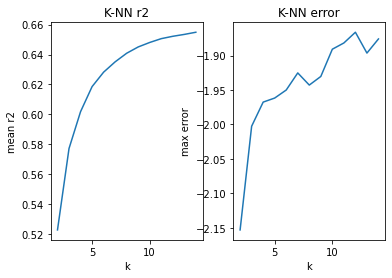

In [48]:
# Having selected the best k, fit and compare on all data for comparison to other methods
# Here we can see how bias and variance (as represented by r2 and max error) can be traded off
fig = plt.figure()
f1 = fig.add_subplot(1,2,1)
f1.plot(range(2,15), [np.mean(knn['test_r2']) for knn in results])
f1.set_xlabel("k")
f1.set_ylabel("mean r2")
f1.set_title("K-NN r2")
f2 = fig.add_subplot(1,2,2)
f2.plot(range(2,15), [np.mean(knn['test_max_error']) for knn in results])
f2.set_xlabel("k")
f2.set_ylabel("max error")
f2.set_title("K-NN error")
# We choose 7 as it gives a nice trade off of max error and the bias (approximated by r^2)
knnrpipe = knnrs[6] 
knnrpipe.fit(X,y)  
print();
print_all_metrics("knnr all", y, knnrpipe.predict(X))

# even with using the whole training set we still get a large max error that is why we do not choose it 
#(NOT DUE TO OVERFITTING!)

# Neural Networks

In [28]:
## Get non-winsorized data Prepare training data since NNs we want to be trained with greater data samples
peruTraining = peru.copy(deep=True)
peruTraining.dropna(axis='index', inplace=True)
peruTraining.drop(['id_for_matlab', 'poor', 'hhid', 'training', 'percapitaconsumption', 'lncaphat_OLS', 'percapitahat_OLS'], axis='columns', inplace=True)
peruTraining.head()
y = peruTraining['lnpercapitaconsumption']
X = peruTraining.drop('lnpercapitaconsumption', axis='columns')


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, train_size=0.8)

In [35]:
# logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
# alpha = L2 penalty (regularization term) parameter
# Tol = Tolerance for the optimization. When the loss or score is not improving by at least tol
mlplogistic= MLPRegressor(max_iter=50000,  activation='logistic', tol=1e-7)
mlplogisticpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', mlplogistic)])
mlplogisticpipe.fit(X_train, y_train)
## Using default tolerance
print_all_metrics("mlplogistic", y_test, mlplogisticpipe.predict(X_test))

mlplogistic r2: 0.5868622663867629
mlplogistic explained_variance_score: 0.589238989237068
mlplogistic max_error: 2.150077886721279
mlplogistic mean absolute error: 0.3688053038763815
mlplogistic mean squared error: 0.22566519890638204


In [36]:
# Here due to training times, we go to a single train / test, no CV - even with less data, it performs better that is why we choose it
# Bad Bias-Variance Trade off?? Quite high variance of MSE for different runs
alpha=1e-2
from sklearn.neural_network import MLPRegressor
mlp= MLPRegressor(max_iter=50000, activation='logistic', alpha=alpha, tol=1e-7)
mlppipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', mlp)])
mlppipe.fit(X_train, y_train)

##
print_all_metrics("mlp", y_test, mlppipe.predict(X_test))

mlp r2: 0.6958399255960204
mlp explained_variance_score: 0.6977176230153983
mlp max_error: 2.2635417882409206
mlp mean absolute error: 0.3150712704407482
mlp mean squared error: 0.16613913013815984


In [37]:
#alpha=1e-2
mlptanh= MLPRegressor(max_iter=50000, activation='tanh', alpha=alpha, tol=1e-7)
mlptanhpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', mlptanh)])
mlptanhpipe.fit(X_train, y_train)
##
print_all_metrics("mlptanh", y_test, mlptanhpipe.predict(X_test))

mlptanh r2: 0.6785899755403825
mlptanh explained_variance_score: 0.6827991877012565
mlptanh max_error: 2.2098535115254023
mlptanh mean absolute error: 0.32553213667247155
mlptanh mean squared error: 0.17556144403910912


# Random Forest

In [38]:
#With winsorizing as RF are sensitive to outliers
peruTraining['h_hhsize'].value_counts(dropna=False).sort_index(ascending = True)
from scipy.stats.mstats import winsorize
winsorize(a=peruTraining['h_hhsize'], limits=[0., 0.05], inplace=True)
peruTraining['h_hhsize'].value_counts(dropna=False).sort_index(ascending = True)
y = peruTraining['lnpercapitaconsumption']
X = peruTraining.drop('lnpercapitaconsumption', axis='columns')

In [39]:
#With winsorizing
rrfr = RandomForestRegressor(criterion="mse", random_state=44)
rrfrpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', rrfr)])
rrfrpipe.fit(X_train, y_train)
print_all_metrics("rrfr", y_test, rrfrpipe.predict(X_test))

rrfr r2: 0.6524398707626378
rrfr explained_variance_score: 0.6527126324399746
rrfr max_error: 2.1285096199999973
rrfr mean absolute error: 0.3386484987026559
rrfr mean squared error: 0.1898452242798579


In [40]:
extr = ExtraTreesRegressor(criterion="mse", random_state=44)
extrpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', extr)])
extrpipe.fit(X_train, y_train)
print_all_metrics("extr", y_test, extrpipe.predict(X_test))

extr r2: 0.5441107004655377
extr explained_variance_score: 0.544280254850225
extr max_error: 2.575602999999995
extr mean absolute error: 0.38137650651071037
extr mean squared error: 0.2490170736983472


# Kernel Ridge

In [49]:
# with winsoirzing
kridgepipe = None
def kridgeInvestigate(alpha, cv=2):

  # Find what sort of magnitude we should be using
  kridge = KernelRidge(alpha=alpha, kernel='poly', degree=2)
  kridgepipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', kridge)])
  return cross_validate(kridgepipe, X, y, scoring=scorers, cv=cv, n_jobs=2, verbose=True)

kridges = [kridgeInvestigate(0.1),
           kridgeInvestigate(0.1),
           kridgeInvestigate(0.25),
           kridgeInvestigate(0.5)]



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   42.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   42.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   50.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   50.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   38.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   38.2s finished


In [50]:
kridges

[{'fit_time': array([38.62327099, 39.45700526]),
  'score_time': array([1.69308805, 1.68237472]),
  'test_neg_mean_squared_error': array([-0.16849127, -0.16539869]),
  'test_r2': array([0.69786175, 0.70191846]),
  'test_max_error': array([-2.84551031, -1.96828296])},
 {'fit_time': array([48.52330399, 49.06157064]),
  'score_time': array([1.61132288, 1.59301019]),
  'test_neg_mean_squared_error': array([-0.16849127, -0.16539869]),
  'test_r2': array([0.69786175, 0.70191846]),
  'test_max_error': array([-2.84551031, -1.96828296])},
 {'fit_time': array([35.98604798, 35.49320197]),
  'score_time': array([1.4886241 , 1.56539989]),
  'test_neg_mean_squared_error': array([-0.16932012, -0.16642503]),
  'test_r2': array([0.69637546, 0.70006879]),
  'test_max_error': array([-2.95846891, -1.98611563])},
 {'fit_time': array([36.22641611, 36.21952987]),
  'score_time': array([1.88733602, 1.88991523]),
  'test_neg_mean_squared_error': array([-0.17068848, -0.16787924]),
  'test_r2': array([0.69392172

In [53]:
#Kernel Poly_3
def kridgeInvestigate(alpha, cv=2):

  # Find what sort of magnitude we should be using
  kridge = KernelRidge(alpha=alpha, kernel='poly', degree=3)
  kridgepipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', kridge)])
  return cross_validate(kridgepipe, X, y, scoring=scorers, cv=cv, n_jobs=2, pre_dispatch=4, verbose=True)

alphas = np.logspace(-4, 4, 40)
kridges = [kridgeInvestigate(a) for a in alphas ]
print(kridges)



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   17.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   17.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Don

[{'fit_time': array([12.72598314, 12.89404845]), 'score_time': array([3.67674088, 3.59568286]), 'test_neg_mean_squared_error': array([-0.27365198, -0.27538915]), 'test_r2': array([0.50928777, 0.50369363]), 'test_max_error': array([-2.84154466, -2.80325168])}, {'fit_time': array([12.59437346, 12.44018841]), 'score_time': array([3.63664985, 3.74372244]), 'test_neg_mean_squared_error': array([-0.25151021, -0.25239707]), 'test_r2': array([0.54899235, 0.54512998]), 'test_max_error': array([-2.74984002, -2.75511835])}, {'fit_time': array([13.77657461, 13.40394807]), 'score_time': array([3.72722673, 3.82808733]), 'test_neg_mean_squared_error': array([-0.23365949, -0.23402961]), 'test_r2': array([0.58100222, 0.57823181]), 'test_max_error': array([-2.65626326, -2.70822291])}, {'fit_time': array([12.65150237, 12.60984564]), 'score_time': array([3.64524651, 3.65933847]), 'test_neg_mean_squared_error': array([-0.21924154, -0.21942453]), 'test_r2': array([0.60685646, 0.60455309]), 'test_max_error':

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.1s finished


In [54]:
#With winsorized data & optimized - not a real improvement for computational time
#Kernelt Poly_3
def kridgeInvestigate(alpha, cv=2):

  # Find what sort of magnitude we should be using
  kridge = KernelRidge(alpha=alpha, kernel='poly', degree=3)
  kridgepipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', kridge)])
  return cross_validate(kridgepipe, X, y, scoring=scorers, cv=cv, n_jobs=2, pre_dispatch=4, verbose=True)

alphas = np.linspace(0.25, 0.35, 40)
kridges = [kridgeInvestigate(a) for a in alphas ]
print(kridges)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Don

[{'fit_time': array([12.84790778, 13.30795765]), 'score_time': array([3.65622807, 3.51275563]), 'test_neg_mean_squared_error': array([-0.16850907, -0.16535766]), 'test_r2': array([0.69782984, 0.70199241]), 'test_max_error': array([-2.81794463, -1.96775488])}, {'fit_time': array([12.52136111, 12.62536716]), 'score_time': array([3.61590719, 3.56569457]), 'test_neg_mean_squared_error': array([-0.16850797, -0.16535866]), 'test_r2': array([0.69783181, 0.70199061]), 'test_max_error': array([-2.8193373 , -1.96749041])}, {'fit_time': array([12.33572245, 12.42891622]), 'score_time': array([3.62612414, 3.59428787]), 'test_neg_mean_squared_error': array([-0.16850706, -0.16535982]), 'test_r2': array([0.69783344, 0.70198851]), 'test_max_error': array([-2.8207154 , -1.96722724])}, {'fit_time': array([12.4639554, 12.2519114]), 'score_time': array([3.52072001, 3.61916089]), 'test_neg_mean_squared_error': array([-0.16850634, -0.16536114]), 'test_r2': array([0.69783473, 0.70198613]), 'test_max_error': a

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   16.2s finished


In [55]:
#With winsoirzed data - seems to be "best"
kridgepipes = []
def kridgeInvestigate(alpha, cv=2):

  # Find what sort of magnitude we should be using
  kridge = KernelRidge(alpha=alpha, kernel='poly', degree=2)
  kridgepipe_ = Pipeline([('scaler', MinMaxScaler()), ('regressor', kridge)])
  kridgepipes.append(kridgepipe_)
  return cross_validate(kridgepipe_, X, y, scoring=scorers, cv=cv, n_jobs=2, pre_dispatch=4, verbose=True)

kridges = [kridgeInvestigate(0.065),
           kridgeInvestigate(0.07),
           kridgeInvestigate(0.075),
           kridgeInvestigate(0.08)]




[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.5s finished


In [ ]:
# The optimal kernel seems to be 0.065
kridges

# Combining regressions

In [58]:
## Get non-winsorized data Prepare training data since NNs we want to be trained with greater data samples
peruTraining = peru.copy(deep=True)
peruTraining.dropna(axis='index', inplace=True)
peruTraining.drop(['id_for_matlab', 'poor', 'hhid', 'training', 'percapitaconsumption', 'lncaphat_OLS', 'percapitahat_OLS'], axis='columns', inplace=True)
peruTraining.head()
y = peruTraining['lnpercapitaconsumption']
X = peruTraining.drop('lnpercapitaconsumption', axis='columns')


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, train_size=0.8)

In [67]:
#Random Forest, Logistic NN, KNNR, Ridge, Lasso as inputs for NN
mlpcombine = MLPRegressor(hidden_layer_sizes=(5,), max_iter=1000, activation='relu')
stackedRegr = StackingRegressor(estimators=[('rrfr', rrfr),  ('krdige', getRegressor(kridgepipes[1])), ('mlplogr',getRegressor(mlppipe)), ('knnr', getRegressor(knnrpipe)), ('ridge', getRegressor(ridgepipe)), ('lasso', getRegressor(lassopipe))], final_estimator=mlpcombine, n_jobs=2, passthrough=False)
stackedpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', stackedRegr)])
stackedpipe.fit(X_train, y_train)
print_all_metrics("stacked", y_test, stackedpipe.predict(X_test))

stacked r2: 0.692832873153405
stacked explained_variance_score: 0.6967692470282763
stacked max_error: 2.1473657828561166
stacked mean absolute error: 0.3166793414057812
stacked mean squared error: 0.16778165037384468


In [68]:
# Adjusting NN to only "meaningful" input regressions
mlpcombine = MLPRegressor(hidden_layer_sizes=(3,), max_iter=1000, activation='logistic')
stackedRegr = StackingRegressor(estimators=[('mlplogr',getRegressor(mlppipe)), ('knnr', getRegressor(knnrpipe)), ('krdige', getRegressor(kridgepipes[1])), ('ridge', getRegressor(ridgepipe))], final_estimator=mlpcombine, n_jobs=2)
stackedpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', stackedRegr)])
stackedpipe.fit(X_train, y_train, )
print_all_metrics("stacked", y_test, stackedpipe.predict(X_test))

stacked r2: 0.690689073415031
stacked explained_variance_score: 0.691042579731495
stacked max_error: 2.1288313722521846
stacked mean absolute error: 0.3173407959512556
stacked mean squared error: 0.16895264240631908


In [69]:
# Stack all regressions instead of using a NN
# Passtrhough = False, only the predictions of estimators will be used as training data for final_estimator
#default 5-fold cross validation
# Final estimator: Ridge on the outputs of the other estimators
stackedRegr = StackingRegressor(estimators=[('rrfr', rrfr),  ('mlplogr',getRegressor(mlppipe)), ('knnr', getRegressor(knnrpipe)), ('krdige', getRegressor(kridgepipes[1])), ('ridge', getRegressor(ridgepipe)), ('lasso', getRegressor(lassopipe))], n_jobs=2, passthrough=True)
stackedpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', stackedRegr)])
stackedpipe.fit(X_train, y_train)
print_all_metrics("stacked", y_test, stackedpipe.predict(X_test))

stacked r2: 0.6987359298470481
stacked explained_variance_score: 0.6989373200006819
stacked max_error: 2.18490976818744
stacked mean absolute error: 0.31323348629559067
stacked mean squared error: 0.16455726694298212


In [70]:
#Adjust stacking
stackedRegr = StackingRegressor(estimators=[('mlplogr',getRegressor(mlppipe)), ('knnr', getRegressor(knnrpipe)), ('ridge', getRegressor(ridgepipe)), ('krdige', getRegressor(kridgepipes[1]))], n_jobs=2, passthrough=False)
stackedpipe = Pipeline([('scaler', MinMaxScaler()), ('regressor', stackedRegr)])
stackedpipe.fit(X_train, y_train)
print_all_metrics("stacked", y_test, stackedpipe.predict(X_test))

stacked r2: 0.6985348774741085
stacked explained_variance_score: 0.698538809295471
stacked max_error: 2.1735578624367102
stacked mean absolute error: 0.31391397032979873
stacked mean squared error: 0.16466708630838658


# Output predictions 

The submission should be in a CSV file format, mimicking the format of the file peru_for_ml_course.csv, but should contain columns with variables named “id_for_matlab”, “hhid”, “training”, “lnpercapitaconsumption “, “groupprediction” in that order. The column “groupprediction” should contain group’s predictions. The other columns should be the same as with the original data file

In [71]:
outputCols = []
peruPredict = peru.copy(deep=True)

dontfittocolumns = ['lnpercapitaconsumption', 'id_for_matlab', 'poor', 'hhid', 'training', 'percapitaconsumption', 'lncaphat_OLS', 'percapitahat_OLS', *outputCols]
peruPredict = peruPredict.dropna(subset=peruPredict.columns.drop(dontfittocolumns, errors='ignore'), axis=0)
peruPredictX = peruPredict.drop(columns=dontfittocolumns, errors='ignore', inplace=False)

In [72]:
#With/Without winsorizing
winzorize = True

peruTraining = peru.copy(deep=True)
peruTraining.dropna(axis='index', inplace=True)
peruTraining.drop(dontfittocolumns[1:], inplace=True, axis='columns')

if (winzorize):
    peruTraining['h_hhsize'].value_counts(dropna=False).sort_index(ascending = True)
    winsorize(a=peruTraining['h_hhsize'], limits=[0., 0.05], inplace=True)
y = peruTraining['lnpercapitaconsumption']
X = peruTraining.drop('lnpercapitaconsumption', axis='columns')

In [73]:
estimator = mlplogisticpipe
outputCol = 'groupprediction'
outputCols.append(outputCol)

fittedEstimator = estimator.fit(X, y)
print_all_metrics("Final, train and tested", y, fittedEstimator.predict(X))

predictedY = fittedEstimator.predict(peruPredictX)

peruPredict[outputCol]  = predictedY

Final, train and tested r2: 0.7961015998985497
Final, train and tested explained_variance_score: 0.7964206505954503
Final, train and tested max_error: 1.9696135411886138
Final, train and tested mean absolute error: 0.26194320103933794
Final, train and tested mean squared error: 0.11343183264139303


In [74]:
estimator = stackedpipe
outputCol = 'groupprediction2'
outputCols.append(outputCol)

fittedEstimator = estimator.fit(X, y)
print_all_metrics("Final, train and tested", y, fittedEstimator.predict(X))

predictedY = fittedEstimator.predict(peruPredictX)
peruPredict[outputCol]  = predictedY

Final, train and tested r2: 0.7216660388871476
Final, train and tested explained_variance_score: 0.7216663343484622
Final, train and tested max_error: 2.534222969576745
Final, train and tested mean absolute error: 0.30516134074965406
Final, train and tested mean squared error: 0.15484148615026083


In [75]:
#Write out CSV
finalOutputsCols = ['id_for_matlab', 'hhid', 'training', 'lnpercapitaconsumption', *outputCols]
print(peruPredict.describe())
print(finalOutputsCols)
outputfile = './peru_for_ml_course_predictions.csv'
peruOut = peruPredict.copy(deep=True)
peruOut.reindex()
peruOut.to_csv(path_or_buf=outputfile, columns=finalOutputsCols, header=True, index=False)



       lnpercapitaconsumption  d_fuel_other   d_fuel_wood   d_fuel_coal  \
count            22674.000000  45378.000000  45378.000000  45378.000000   
mean                 5.849424      0.105910      0.312332      0.025056   
std                  0.745882      0.307726      0.463450      0.156298   
min                  2.110213      0.000000      0.000000      0.000000   
25%                  5.335076      0.000000      0.000000      0.000000   
50%                  5.870931      0.000000      0.000000      0.000000   
75%                  6.354526      0.000000      1.000000      0.000000   
max                  8.858051      1.000000      1.000000      1.000000   

       d_fuel_kerosene    d_fuel_gas  d_fuel_electric   d_fuel_none  \
count     45378.000000  45378.000000     45378.000000  45378.000000   
mean          0.004474      0.513465         0.007757      0.031006   
std           0.066735      0.499824         0.087733      0.173336   
min           0.000000      0.000000    

In [ ]:
y.describe()

In [56]:
import dill
dill.dump_session('notebook_env.db')

ModuleNotFoundError: No module named 'dill'

In [1]:
import dill
dill.load_session('notebook_env.db')

AttributeError: module 'IPython.core' has no attribute 'shadowns'